In [1]:
import pandas as pd
import numpy as np
from scipy import stats, spatial
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from trackml.dataset import load_event
import statsmodels.api as sm

seed = 1235

rand = np.random.RandomState(seed)

In [2]:
event_nums = np.arange(0,99)
n_events = 1
chosen_events = rand.choice(event_nums, n_events, replace=True)
hit_list = []; cell_list = []; particle_list = []; truth_list = []
for event_num in chosen_events:
    eventstring = 'data/train_100_events/event0000010%02d' %(event_num)
    hits, cells, particles, truth = load_event(eventstring)
    hit_list.append(hits)
    cell_list.append(cells)
    particle_list.append(particles)
    truth_list.append(truth)
hits = pd.concat(hit_list, 0)
cells = pd.concat(cell_list, 0)
particles = pd.concat(particle_list, 0)
truth = pd.concat(truth_list, 0)

In [3]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-85.680199,-0.95032,-1502.5,7,2,1
1,2,-77.881897,-5.40219,-1502.5,7,2,1
2,3,-55.414299,-6.97355,-1502.5,7,2,1
3,4,-96.542397,-6.31911,-1502.5,7,2,1
4,5,-60.598499,-4.19243,-1502.5,7,2,1


In [4]:
cells.head()

,hit_id,ch0,ch1,value
0,1,52,986,0.300639
1,2,153,854,0.302578
2,3,220,458,0.166070
3,3,219,458,0.117359
4,4,142,1186,0.293928


In [5]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503737066323968,-0.012758,-0.03171,5.33763,3.657540,2.116990,-3.732140,-1,5
1,4503943224754176,-0.012758,-0.03171,5.33763,0.674862,0.554618,-1.041510,-1,7
2,4504011944230912,-0.012758,-0.03171,5.33763,0.863362,0.544326,1.778080,1,11
3,4504080663707648,-0.012758,-0.03171,5.33763,3.000560,-1.875640,-2.194470,-1,11
4,4504149383184384,-0.012758,-0.03171,5.33763,1.684900,-0.908058,-0.988944,1,10


In [6]:
np.unique(particles.q)

array([-1,  1], dtype=int32)

In [7]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,328765109260255232,-85.670097,-0.963904,-1502.5,-0.493454,-0.027191,-8.73463,0.000007
1,2,216180066378317824,-77.890297,-5.421440,-1502.5,-1.481370,-0.082942,-28.66670,0.000019
2,3,369328360951644160,-55.396900,-6.968120,-1502.5,-0.248833,0.029517,-6.72002,0.000024
3,4,171143726507229184,-96.530602,-6.312230,-1502.5,-0.396131,-0.059384,-6.23145,0.000009
4,5,594487176721334272,-60.579399,-4.183970,-1502.5,-0.395276,-0.008543,-9.65867,0.000008


# Paths?

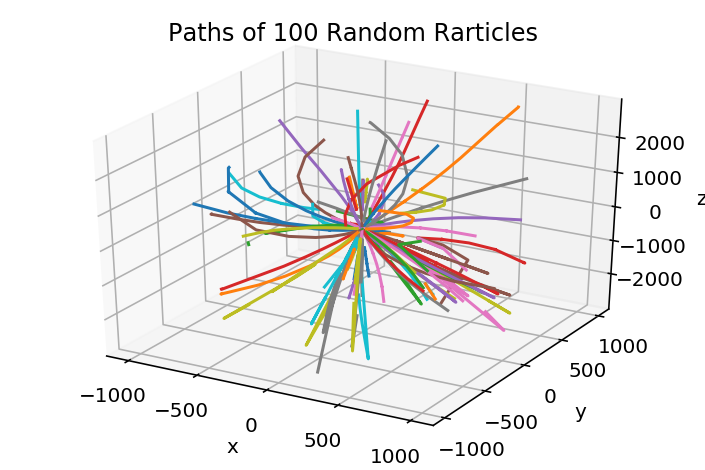

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('x')
ax.set_xticks([-1000, -500, 0, 500, 1000])
ax.set_ylabel('y')
ax.set_yticks([-1000, -500, 0, 500, 1000])
ax.set_zlabel('z')
plt.title('Paths of 100 Random Rarticles')

particle_ids = np.unique(particles.particle_id)[1:100]
for particle_id in particle_ids:
    hit_ids = truth[truth.particle_id == particle_id]['hit_id']
    particle_hits = hits.loc[hit_ids-1]
    
    ax.plot(particle_hits.x.values, particle_hits.y.values, particle_hits.z.values)
    
plt.show()

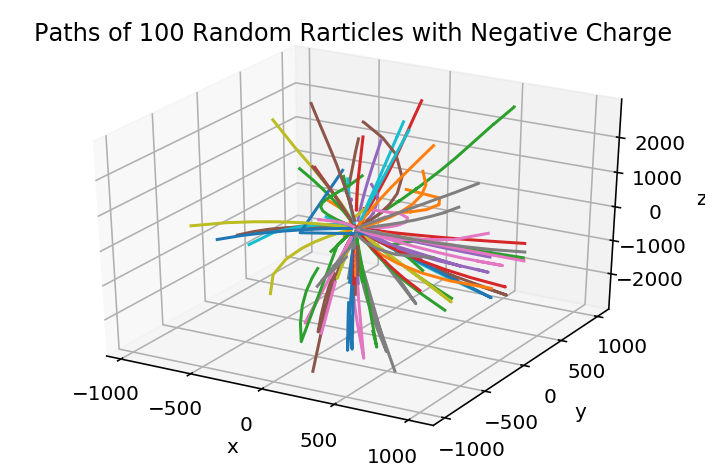

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('x')
ax.set_xticks([-1000, -500, 0, 500, 1000])
ax.set_ylabel('y')
ax.set_yticks([-1000, -500, 0, 500, 1000])
ax.set_zlabel('z')
plt.title('Paths of 100 Random Rarticles with Negative Charge')

particle_ids = np.unique(particles[particles.q == -1].particle_id)[1:100]
for particle_id in particle_ids:
    hit_ids = truth[truth.particle_id == particle_id]['hit_id']
    particle_hits = hits.loc[hit_ids-1]
    
    ax.plot(particle_hits.x.values, particle_hits.y.values, particle_hits.z.values)
    
plt.show()

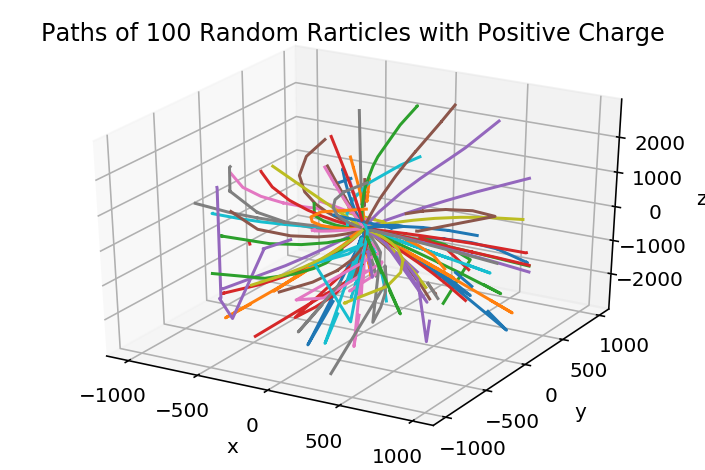

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('x')
ax.set_xticks([-1000, -500, 0, 500, 1000])
ax.set_ylabel('y')
ax.set_yticks([-1000, -500, 0, 500, 1000])
ax.set_zlabel('z')
plt.title('Paths of 100 Random Rarticles with Positive Charge')

particle_ids = np.unique(particles[particles.q == 1].particle_id)[1:100]
for particle_id in particle_ids:
    hit_ids = truth[truth.particle_id == particle_id]['hit_id']
    particle_hits = hits.loc[hit_ids-1]
    
    ax.plot(particle_hits.x.values, particle_hits.y.values, particle_hits.z.values)
    
plt.show()

# Angles

In [11]:
def angle(u,v):
    costheta = (np.dot(u,v)/np.sqrt(np.dot(u,u)*np.dot(v,v)))
    return(np.arccos(costheta)*180/np.pi)

In [12]:
pos_angles = []
particle_ids = np.unique(particles[particles.q == 1].particle_id)[:500]
for particle_id in particle_ids:
    hit_ids = truth[truth.particle_id == particle_id]['hit_id']
    particle_hits = hits.loc[hit_ids-1]
    if len(particle_hits >=3):

        diff_hits = particle_hits[['x','y','z']].diff().reset_index()[1:]
        del diff_hits['index']
        diff_hits

        for i in diff_hits.index.values[:-1]:
            u = diff_hits.loc[i]; v = diff_hits.loc[i+1]
            pos_angles.append(angle(u,v))
pos_angles = np.array(pos_angles)

/home/hudson/anaconda3/envs/math189/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arccos
  This is separate from the ipykernel package so we can avoid doing imports until


(array([2.019e+03, 9.200e+01, 2.000e+01, 1.500e+01, 1.000e+00, 5.000e+00,
        8.000e+00, 3.000e+01, 6.600e+01, 9.320e+02]),
 array([  0.        ,  18.0000005 ,  36.000001  ,  54.0000015 ,
         72.000002  ,  90.0000025 , 108.00000301, 126.00000351,
        144.00000401, 162.00000451, 180.00000501]),
 <a list of 10 Patch objects>)

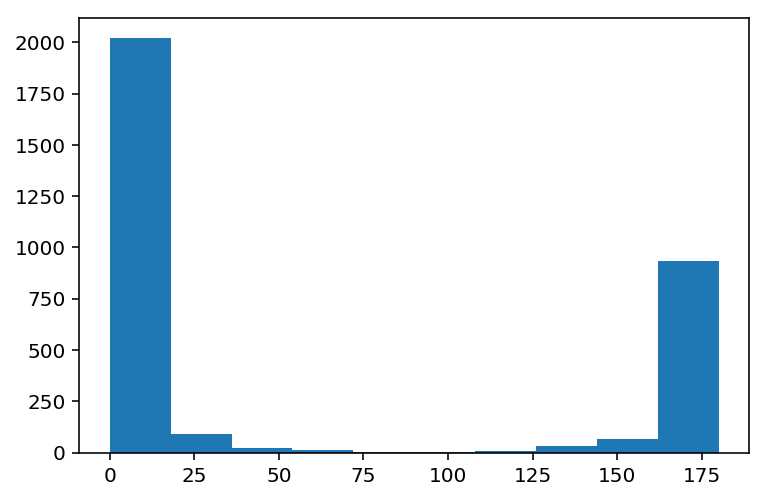

In [13]:
plt.hist(pos_angles[~np.isnan(pos_angles)])

/home/hudson/anaconda3/envs/math189/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/hudson/anaconda3/envs/math189/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(array([18., 14., 14.,  2.,  0.,  3.,  2.,  8.,  9., 37.]),
 array([ 30.56745295,  42.46669912,  54.36594528,  66.26519144,
         78.16443761,  90.06368377, 101.96292994, 113.8621761 ,
        125.76142227, 137.66066843, 149.5599146 ]),
 <a list of 10 Patch objects>)

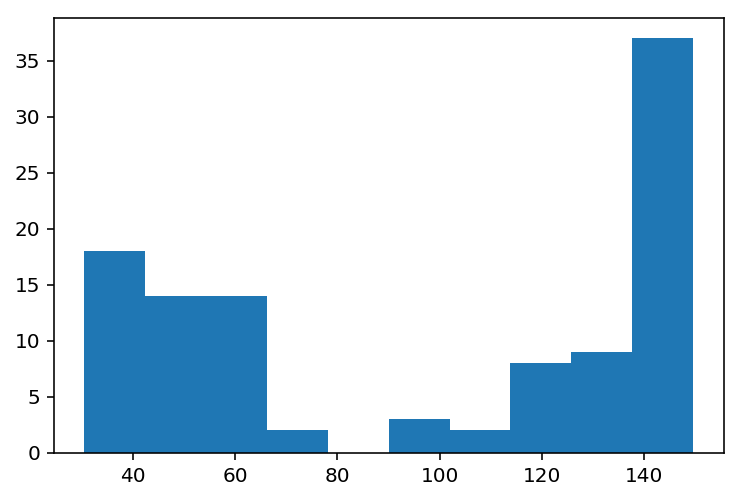

In [14]:
plt.hist(pos_angles[(~np.isnan(pos_angles)) & (pos_angles > 30) & (pos_angles < 150)])

In [15]:
neg_angles = []
particle_ids = np.unique(particles[particles.q == -1].particle_id)[:500]
for particle_id in particle_ids:
    hit_ids = truth[truth.particle_id == particle_id]['hit_id']
    particle_hits = hits.loc[hit_ids-1]
    if len(particle_hits >=3):

        diff_hits = particle_hits[['x','y','z']].diff().reset_index()[1:]
        del diff_hits['index']
        diff_hits

        for i in diff_hits.index.values[:-1]:
            u = diff_hits.loc[i]; v = diff_hits.loc[i+1]
            neg_angles.append(angle(u,v))
neg_angles = np.array(neg_angles)

/home/hudson/anaconda3/envs/math189/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arccos
  This is separate from the ipykernel package so we can avoid doing imports until


(array([2.482e+03, 9.100e+01, 1.400e+01, 1.100e+01, 1.000e+00, 3.000e+00,
        5.000e+00, 5.000e+00, 2.500e+01, 8.760e+02]),
 array([  0.        ,  18.0000005 ,  36.000001  ,  54.0000015 ,
         72.000002  ,  90.0000025 , 108.00000301, 126.00000351,
        144.00000401, 162.00000451, 180.00000501]),
 <a list of 10 Patch objects>)

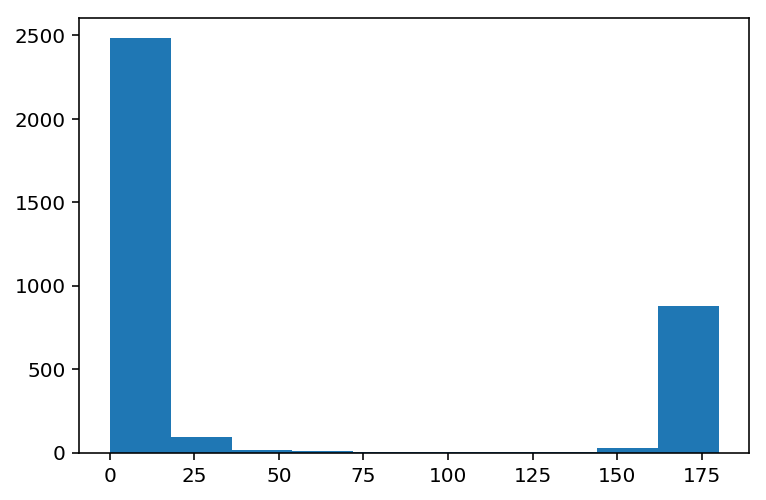

In [16]:
plt.hist(neg_angles[~np.isnan(neg_angles)])

# First Angle vs Initial Momentum?

In [17]:
pos_angles = []
particle_ids = np.unique(particles[particles.q == 1].particle_id)[:500]
for particle_id in particle_ids:
    hit_ids = truth[truth.particle_id == particle_id]['hit_id']
    particle_hits = hits.loc[hit_ids-1]
    diff_hits = particle_hits[['x','y','z']].diff().reset_index()[1:]
    del diff_hits['index']
    if len(diff_hits) >=2:
        u = diff_hits.iloc[0]; v = diff_hits.iloc[1]
        a = angle(u,v)
        momenta = particles[particles.particle_id == particle_id][['px','py','pz']].values[0]
        momentum = np.sqrt(np.dot(momenta, momenta))
        pos_angles.append([a, momentum])
pos_angles = np.array(pos_angles)

## No relationship between momentum and first angle

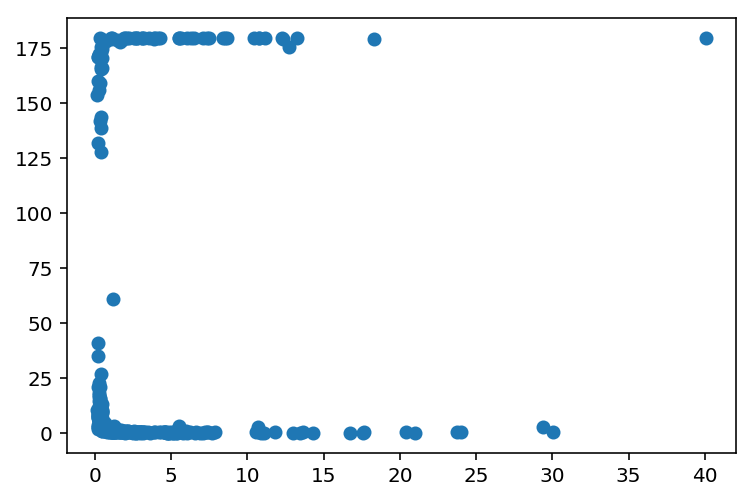

In [18]:
plt.scatter(pos_angles[:,1], pos_angles[:,0])

# Angle of incidence vs angle of reflection?

In [19]:
detectors = pd.read_csv('data/detectors.csv')
detectors.head()

,volume_id,layer_id,module_id,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,...,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhu,module_maxhu,module_hv,pitch_u,pitch_v
0,7,2,1,-65.7965,-5.17830,-1502.5,0.078459,-0.996917,0.0,-0.996917,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
1,7,2,2,-139.8510,-6.46568,-1502.0,0.046183,-0.998933,0.0,-0.998933,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
2,7,2,3,-138.6570,-19.34190,-1498.0,0.138156,-0.990410,0.0,-0.990410,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
3,7,2,4,-64.1764,-15.40740,-1498.0,0.233445,-0.972370,0.0,-0.972370,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
4,7,2,5,-136.2810,-32.05310,-1502.0,0.228951,-0.973438,0.0,-0.973438,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625


In [20]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-85.680199,-0.95032,-1502.5,7,2,1
1,2,-77.881897,-5.40219,-1502.5,7,2,1
2,3,-55.414299,-6.97355,-1502.5,7,2,1
3,4,-96.542397,-6.31911,-1502.5,7,2,1
4,5,-60.598499,-4.19243,-1502.5,7,2,1


In [21]:
angles_in = []
angles_out = []
angles_total = []
dots_in = []
dots_out = []
detector_positions = []
detector_normals = []
particles_data = []

particle_ids = np.unique(particles.particle_id)[:500]
for particle_id in particle_ids:
    hit_ids = truth[truth.particle_id == particle_id]['hit_id']
    if len(hit_ids) >=3:
        particles_data.append(particle_id)
        hit_1 = hit_ids.iloc[0]
        hit_2 = hit_ids.iloc[1]
        hit_3 = hit_ids.iloc[2]

        vec_in = hits.iloc[hit_2-1][['x','y','z']] - hits.loc[hit_1-1][['x','y','z']]
        vec_out = hits.iloc[hit_3-1][['x','y','z']] - hits.loc[hit_2-1][['x','y','z']]

        detector_id = hits.loc[hit_2-1][['volume_id','layer_id','module_id']].values
        detector = detectors[(detectors['volume_id'] == detector_id[0]) & (detectors['layer_id'] == detector_id[1]) & (detectors['module_id'] == detector_id[2])]

        detector_pos = detector[['cx', 'cy', 'cz']].values[0]
        detector_positions.append(detector_pos)
        rotation_mat = detector[['rot_xu', 'rot_xv','rot_xw', 'rot_yu', 'rot_yv','rot_yw', 'rot_zu', 'rot_zv','rot_zw']]
        rotation_mat = rotation_mat.values.reshape(3,3) 
        normal = rotation_mat @ np.array([0,0,1])
        detector_normals.append(normal)

        dot_in = np.dot(vec_in, normal)
        angle_in = angle(vec_in, normal)
        dot_out = np.dot(vec_out, normal)
        angle_out = angle(normal, vec_out)
        angle_total = angle(vec_in, vec_out)

        angles_in.append(angle_in)
        angles_out.append(angle_out)
        angles_total.append(angle_total)
        dots_in.append(dot_in)
        dots_out.append(dot_out)

In [22]:
associated_particles = particles[np.in1d(particles.particle_id, np.array(particles_data))]

# Some hits come from beind, some from the front

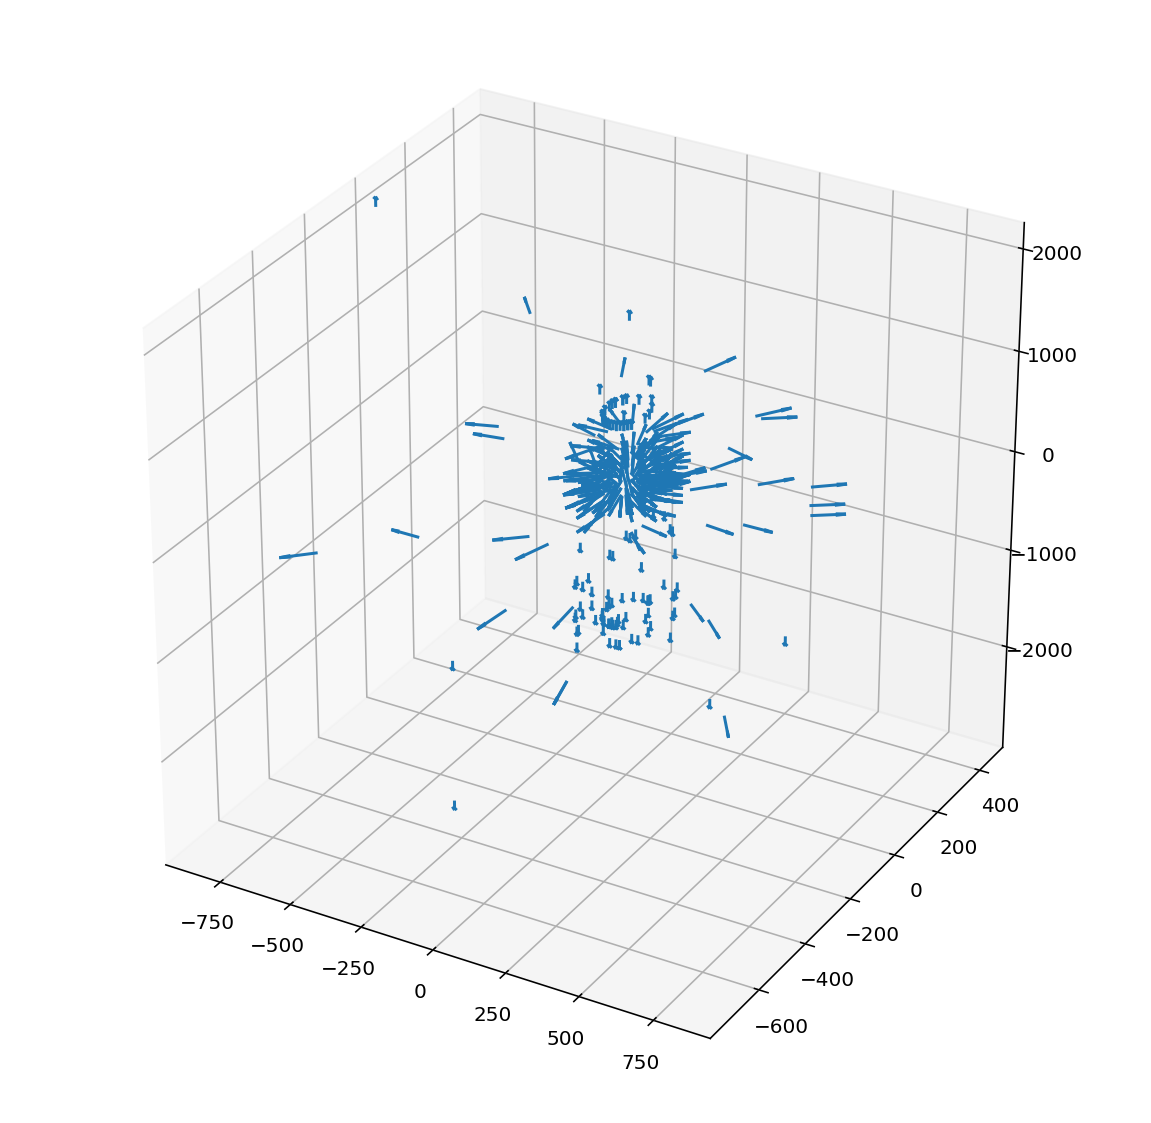

In [23]:
x, y, z = list(zip(*detector_positions))
u,v,w = list(zip(*detector_normals))
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.quiver(x, y, z, u, v, w, length=100)

(array([  4.,  53., 329.,  12.,   1.,   1.,   1.,   0.,   0.,   1.]),
 array([-401.  , -215.25,  -29.5 ,  156.25,  342.  ,  527.75,  713.5 ,
         899.25, 1085.  , 1270.75, 1456.5 ]),
 <a list of 10 Patch objects>)

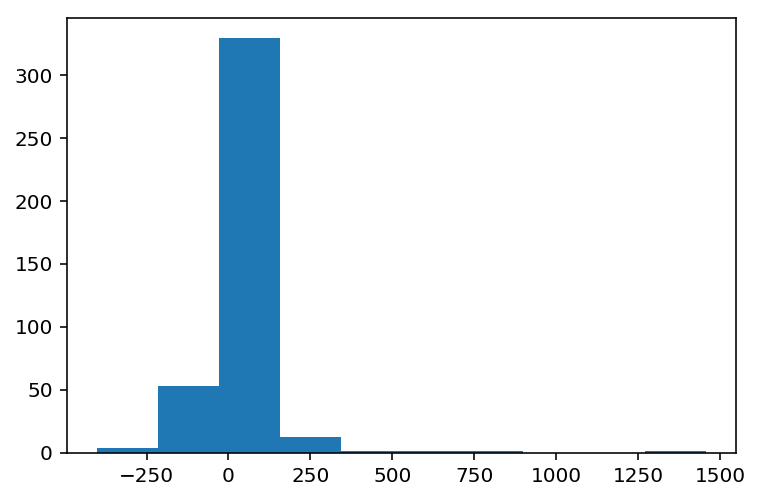

In [24]:
plt.hist(dots_in)

(array([62., 67., 72., 76., 24., 12.,  2.,  3.,  4., 80.]),
 array([  2.2408306 ,  19.80923478,  37.37763895,  54.94604312,
         72.5144473 ,  90.08285147, 107.65125565, 125.21965982,
        142.78806399, 160.35646817, 177.92487234]),
 <a list of 10 Patch objects>)

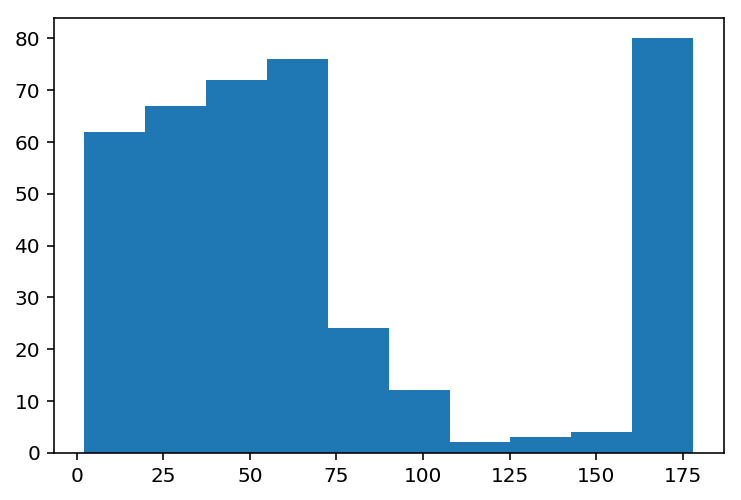

In [25]:
plt.hist(angles_in)

(array([  6.,  43., 308.,  42.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([-523.0313835 , -326.07824515, -129.1251068 ,   67.82803155,
         264.7811699 ,  461.73430825,  658.6874466 ,  855.64058495,
        1052.5937233 , 1249.54686165, 1446.5       ]),
 <a list of 10 Patch objects>)

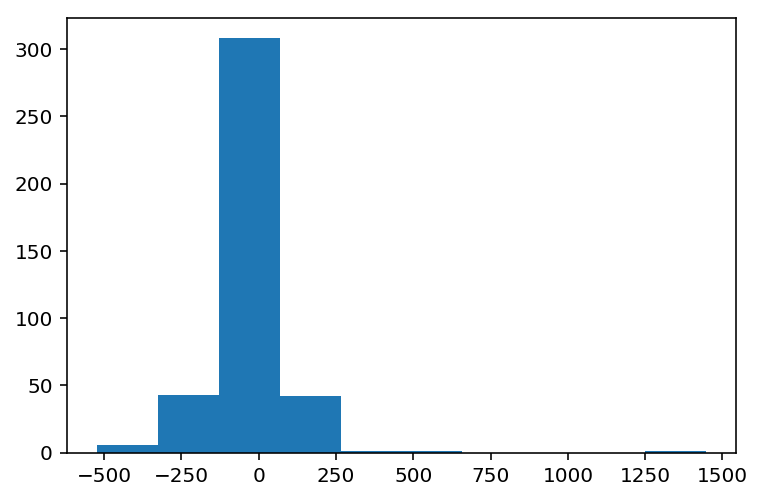

In [26]:
plt.hist(dots_out)

(array([70., 61., 74., 81., 35.,  2.,  2.,  3.,  6., 68.]),
 array([  1.96028248,  19.55509273,  37.14990298,  54.74471322,
         72.33952347,  89.93433372, 107.52914396, 125.12395421,
        142.71876446, 160.31357471, 177.90838495]),
 <a list of 10 Patch objects>)

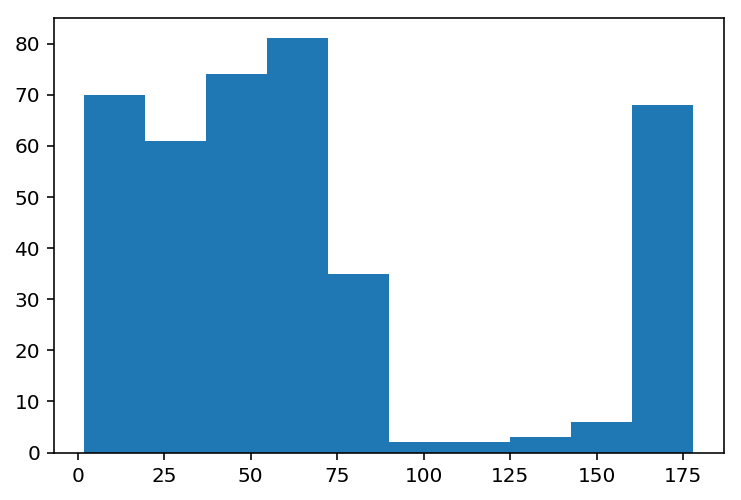

In [27]:
plt.hist(angles_out)

(array([312.,   6.,   1.,   1.,   0.,   0.,   1.,   2.,   3.,  76.]),
 array([2.79764548e-02, 1.80251793e+01, 3.60223822e+01, 5.40195850e+01,
        7.20167879e+01, 9.00139907e+01, 1.08011194e+02, 1.26008396e+02,
        1.44005599e+02, 1.62002802e+02, 1.80000005e+02]),
 <a list of 10 Patch objects>)

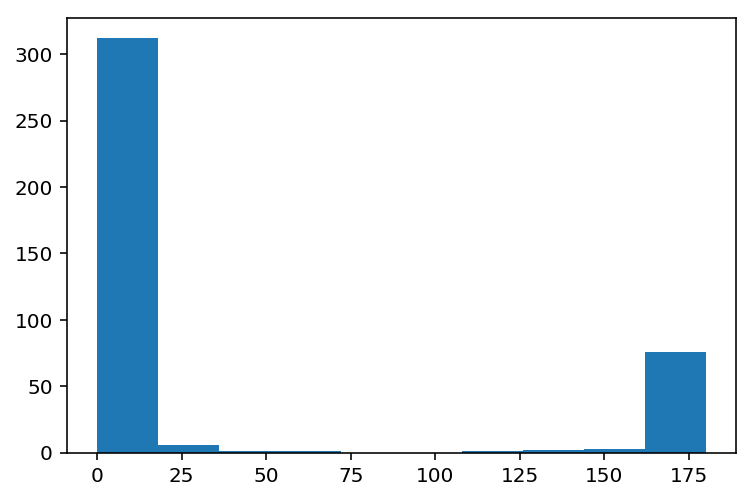

In [28]:
plt.hist(angles_total)

(array([46., 59., 70., 74., 99.,  5.,  0.,  1.,  1., 47.]),
 array([  8.0245292 ,  42.79439285,  77.56425649, 112.33412014,
        147.10398378, 181.87384743, 216.64371108, 251.41357472,
        286.18343837, 320.95330201, 355.72316566]),
 <a list of 10 Patch objects>)

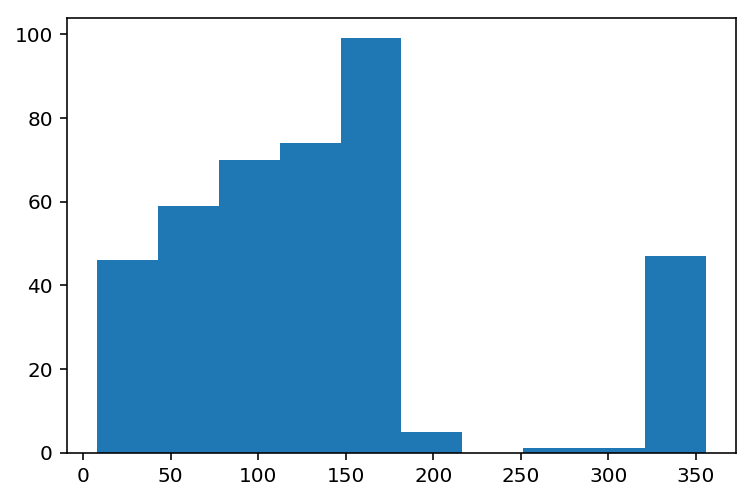

In [29]:
plt.hist(np.array(angles_in) + np.array(angles_out))

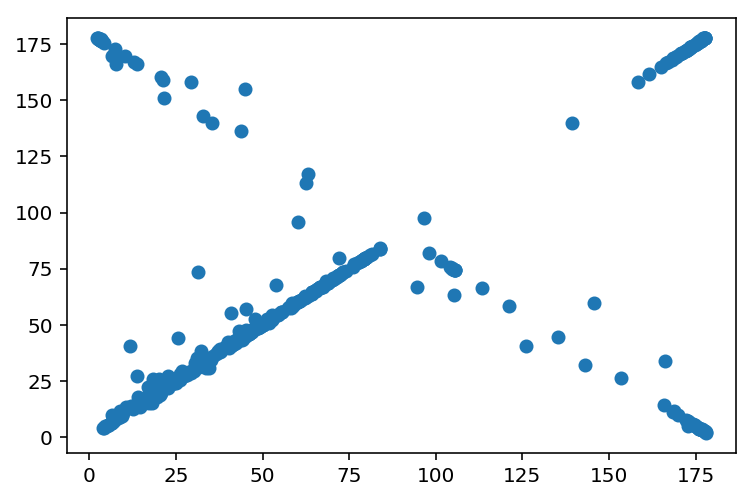

In [30]:
plt.scatter(angles_in, angles_out)

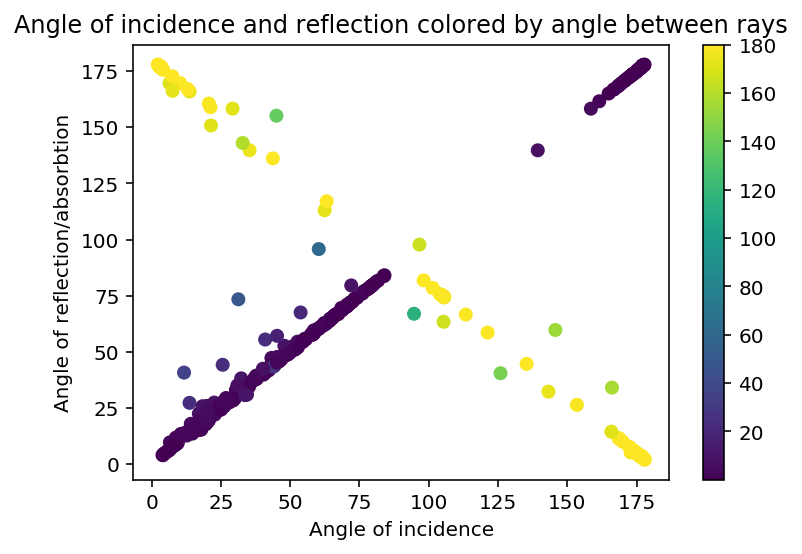

In [31]:
plt.scatter(angles_in, angles_out, c=angles_total)
plt.xlabel('Angle of incidence')
plt.ylabel('Angle of reflection')
plt.colorbar()
plt.title("Angle of incidence and reflection colored by angle between rays")
plt.show()

## Test of proportion

In [65]:
reflect = np.array(angles_total) >= 90
print(np.mean(reflect))
through = np.array(angles_total) < 90
print(np.mean(through))

0.20398009950248755
0.7960199004975125


In [79]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest(sum(reflect), len(reflect), .5)

(-14.729163144972615, 4.1886055112039046e-49)

### Signifigant :)

# Separate X

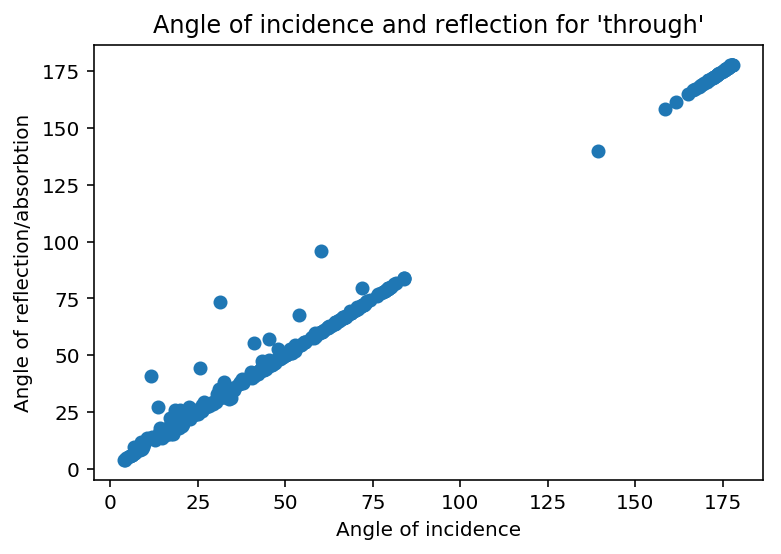

In [34]:
plt.scatter(np.array(angles_in)[through], np.array(angles_out)[through])
plt.xlabel('Angle of incidence')
plt.ylabel('Angle of reflection/absorbtion')
plt.title("Angle of incidence and reflection for 'through'")
plt.show()

In [35]:
through_endog = np.array(angles_out)[through] - np.array(angles_in)[through]
through_exog = np.array(angles_in)[through]

through_ols = sm.RLM(through_endog, through_exog)
through_ols_results = through_ols.fit()
print(through_ols_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  320
Model:                            RLM   Df Residuals:                      319
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 11 Jun 2018                                         
Time:                        19:08:04                                         
No. Iterations:                    11                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0005      0.000      1.818      0.0

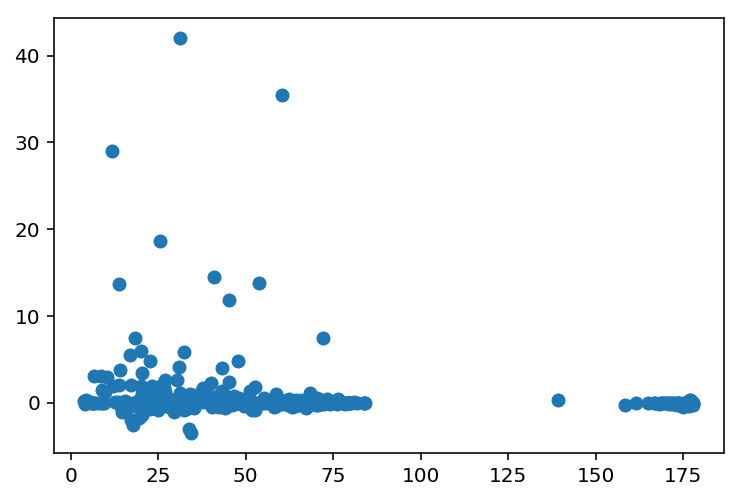

In [36]:
plt.scatter(through_exog, through_ols_results.resid)

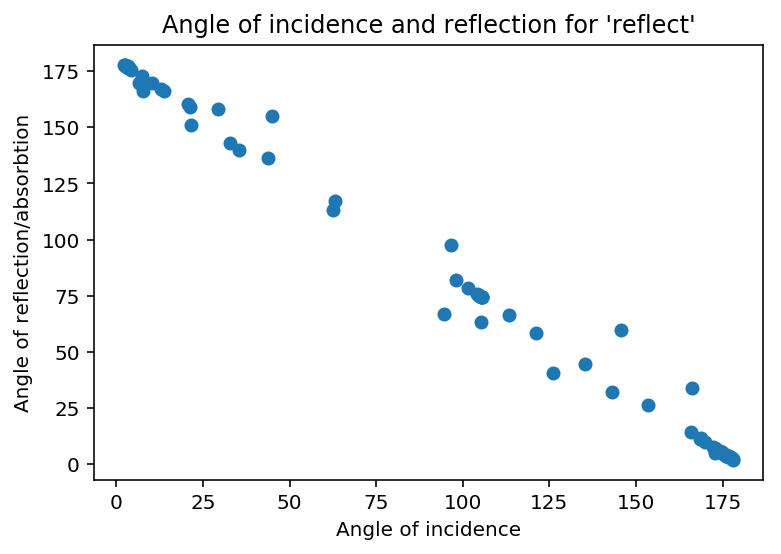

In [37]:
plt.scatter(np.array(angles_in)[reflect], np.array(angles_out)[reflect])
plt.xlabel('Angle of incidence')
plt.ylabel('Angle of reflection/absorbtion')
plt.title("Angle of incidence and reflection for 'reflect'")
plt.show()

In [38]:
reflect_endog = 180 - np.array(angles_out)[reflect] - np.array(angles_in)[reflect]
reflect_exog = np.array(angles_in)[reflect]

reflect_ols = sm.RLM(reflect_endog, reflect_exog)
reflect_ols_results = reflect_ols.fit()
print(reflect_ols_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   82
Model:                            RLM   Df Residuals:                       81
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 11 Jun 2018                                         
Time:                        19:08:05                                         
No. Iterations:                    10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6.132e-05      0.000      0.207      0.8

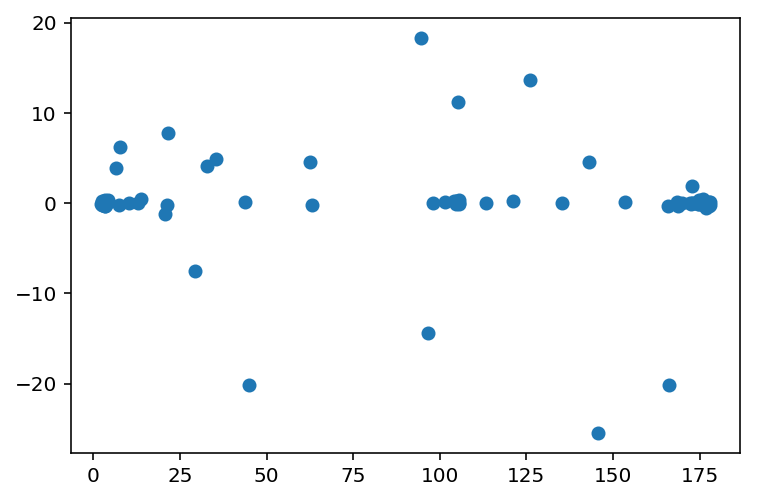

In [39]:
plt.scatter(np.array(angles_in)[reflect], reflect_ols_results.resid)

# Does initial momentum differ across through vs reflect?

In [40]:
momenta_reflect = associated_particles[reflect][['px', 'py','pz']]
momenta_reflect = np.sqrt(np.sum(np.square(momenta_reflect),1))
momenta_reflect.describe()

count    82.000000
mean      3.952345
std       5.996978
min       0.186489
25%       0.495638
50%       1.668691
75%       4.020750
max      32.102566
dtype: float64

In [41]:
momenta_through = associated_particles[through][['px', 'py','pz']]
momenta_through = np.sqrt(np.sum(np.square(momenta_through),1))
momenta_through.describe()

count    320.000000
mean       3.265002
std        4.928945
min        0.155877
25%        0.569630
50%        1.438826
75%        3.908446
max       40.048786
dtype: float64

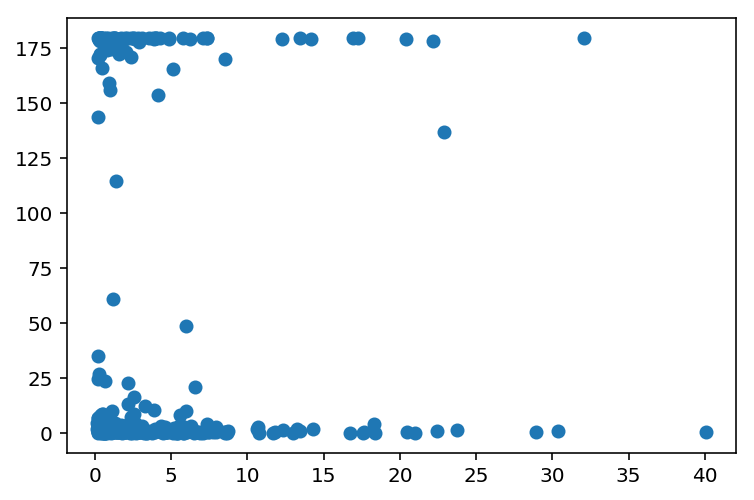

In [42]:
momenta = associated_particles[['px', 'py','pz']]
momenta = np.sqrt(np.sum(np.square(momenta),1))
plt.scatter(momenta, angles_total)

# Difference in momentum!!

In [43]:
from scipy.stats import mannwhitneyu
mannwhitneyu(momenta_through, momenta_reflect)

MannwhitneyuResult(statistic=12703.0, pvalue=0.32863648438908644)

# Does angle of incidence differ across through vs reflect?

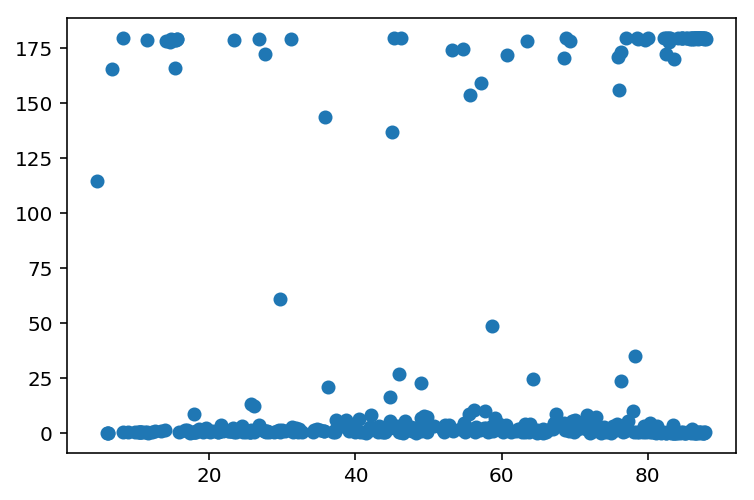

In [44]:
plt.scatter(np.abs(np.array(angles_in)-90), angles_total)

In [45]:
reflect_in = np.abs(90 - np.array(angles_in)[reflect])

(array([ 4.,  8.,  3.,  2.,  3.,  1.,  4.,  4.,  6., 47.]),
 array([ 4.68444807, 13.0084905 , 21.33253292, 29.65657535, 37.98061778,
        46.30466021, 54.62870263, 62.95274506, 71.27678749, 79.60082991,
        87.92487234]),
 <a list of 10 Patch objects>)

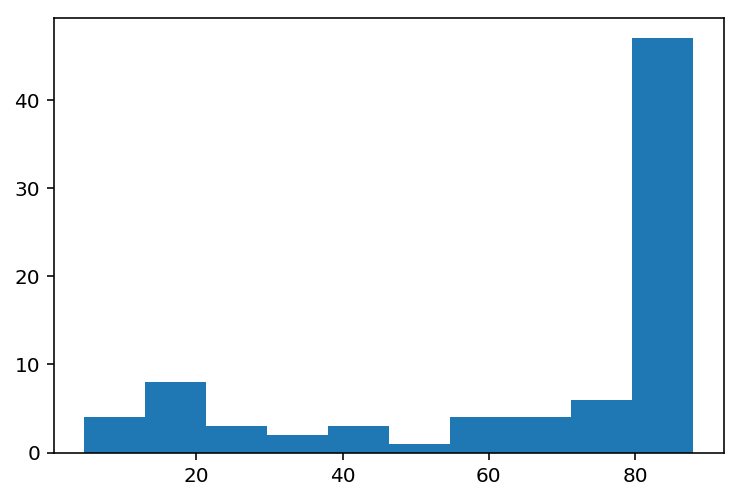

In [46]:
plt.hist(reflect_in)

In [47]:
through_in = np.abs(90-np.array(angles_in)[through])

(array([19., 26., 36., 28., 41., 25., 30., 28., 30., 57.]),
 array([ 5.97657452, 14.16229255, 22.34801057, 30.53372859, 38.71944662,
        46.90516464, 55.09088266, 63.27660069, 71.46231871, 79.64803674,
        87.83375476]),
 <a list of 10 Patch objects>)

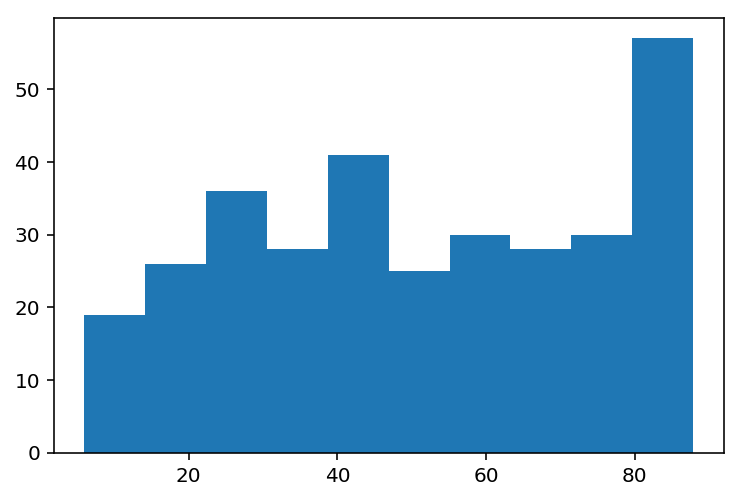

In [48]:
plt.hist(through_in)

In [49]:
from scipy.stats import mannwhitneyu
mannwhitneyu(reflect_in, through_in)

MannwhitneyuResult(statistic=7832.0, pvalue=8.877209066143813e-09)

# Jointly (plus charge)


In [50]:
charge = associated_particles['q']

In [61]:
charge_dummy = (charge == 1).astype(int)

In [62]:
exog = np.transpose(np.vstack(([momenta], [np.abs(np.array(angles_in) - 90)], [charge_dummy])))

In [63]:
logistic_model = sm.GLM(through.astype(int), exog, family=sm.families.Binomial())

In [64]:
logistic_results = logistic_model.fit()
print(logistic_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  402
Model:                            GLM   Df Residuals:                      399
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -225.00
Date:                Mon, 11 Jun 2018   Deviance:                       449.99
Time:                        19:11:45   Pearson chi2:                     420.
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0263      0.024      1.078      0.281      -0.022       0.074
x2             0.0087      0.003      3.161      0.0